## Mini AlexNet Baseline Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [3]:
import sys
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

print(sys.version)
print("numpy version {}".format(np.__version__))
print("tensforflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))
print("sklearn version {}".format(sklearn.__version__))

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version 1.14.2
tensforflow version 1.5.0-dev20171116
keras version 2.0.9
sklearn version 0.19.1


In [64]:
BASELINE_outfile = 'cifar10_alexnet.out'

BASELINE_final_weightfile = 'weights/alexnet.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/alexnet.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 100

BASELINE_init_weighfile = 'weights/alexnet.b16.e0.h5'

REGULARIZED_final_weightfile = 'weights/alexnet.b16.wd.final.h5'
RANDOMIZED_final_weightfile = 'weights/alexnet.b16.rand100.final.h5'

N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

In [5]:
!cd weights; ln -s alexnet.b16.final.h5 alexnet.b16.e100.h5
!cd weights; ls -l alexnet.b16.e100.h5

ln: alexnet.b16.e100.h5: File exists
lrwxr-xr-x  1 charlesmartin14  staff  20 Apr 10 23:41 alexnet.b16.e100.h5 -> alexnet.b16.final.h5


## Baseline 

In [6]:
model = Sequential()
model.add(Conv2D(96, (5, 5), input_shape=(28, 28, 3), kernel_initializer=
                 'glorot_normal', bias_initializer=Constant(0.1), padding=
                 'same', activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5, 5), kernel_initializer='glorot_normal',
                 bias_initializer=Constant(0.1), padding='same',
                 activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(384, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(192, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
model.load_weights(BASELINE_final_weightfile)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

#### Check baseline shapes

In [13]:
for il, layer in enumerate(model.layers):
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print("layer ",il,": ", W.shape)

layer  0 :  (5, 5, 3, 96)
layer  2 :  (96,)
layer  3 :  (5, 5, 96, 256)
layer  5 :  (256,)
layer  7 :  (4096, 384)
layer  8 :  (384, 192)
layer  9 :  (192, 10)


### Generalized Entropy

In [42]:
# model is defined above
def layer_entropy(l=7):
    W = model.layers[l].get_weights()[0]
    return matrix_entropy(W)

In [41]:
# Trace Normalization
def matrix_entropy(W):
    W=W/np.trace(W)
    m = W.shape[1]
    svd = TruncatedSVD(n_components=m-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    rank = np.linalg.matrix_rank(W)
    p = sv*sv
    p = p/np.sum(p)
    
    if (rank==1):
        rank=1.000001
    entropy = - np.sum(p*np.log(p)) / np.log(rank) 
    return entropy


### Read Training Accuracies

We can simply parse these from the output file

In [38]:
def read_training_accuracies(filename):
    cmd = "cat ./{} | grep '50000/' | sed -e 's/.*acc://' ".format(filename)
    !$cmd > tmp.out
    result = np.loadtxt("tmp.out")
    !rm tmp.out
    return result

### Recompute Test Accuracies

In [39]:
img = tf.placeholder(tf.float32, [28, 28, 3])
norm_image = tf.image.per_image_standardization(img)

print("Loading test images...")
cifar10_test_images = []
cifar10_test_labels = []
test_file = open('../data/cifar-10-batches-py/test_batch', 'rb')
test_dict = pickle.load(test_file, encoding='bytes')

for image, label in zip(test_dict[b'data'], test_dict[b'labels']):
    image_red = np.reshape(image[:1024], (32, 32))[2:-2, 2:-2] / 255.0
    image_red = np.reshape(image_red, (28, 28, 1))
    image_green = np.reshape(image[1024:2048], (32, 32))[2:-2,
                                                            2:-2] / 255.0
    image_green = np.reshape(image_green, (28, 28, 1))
    image_blue = np.reshape(image[2048:3072], (32, 32))[2:-2, 2:-2] / 255.0
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image = np.concatenate([image_red, image_green, image_blue], axis=-1)
    image = norm_image.eval(feed_dict={img:image})
    cifar10_test_images.append(image)
    label = np.identity(10)[label]
    cifar10_test_labels.append(label)
test_file.close()

Loading test images...


## BASLINE

### Compute Entropy and Accuracies per Epoch

Baseline has 100 epochs.


In [43]:
w7_entropies, w8_entropies = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    w7_entropies.append(layer_entropy(7))
    w8_entropies.append(layer_entropy(8))

In [53]:
assert(len(w7_entropies)==NUM_BASELINE_EPOCHS)
assert(len(w8_entropies)==NUM_BASELINE_EPOCHS)

Text(0.5,1,'Mini AlexNet: Layer Entropies vs epoch ')

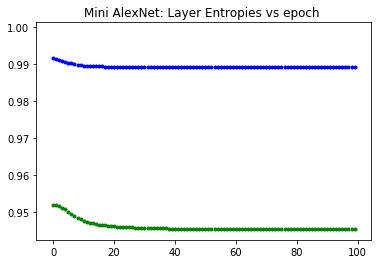

In [44]:
plt.scatter(range(0,len(w7_entropies)), w7_entropies, marker='.', color='blue')
plt.scatter(range(0,len(w8_entropies)), w8_entropies, marker='.', color='green')
#lt.ylim([0.905,0.920])
plt.title('Mini AlexNet: Layer Entropies vs epoch ')

Text(0.5,1,'Mini AlexNet: Layer Entropy 7 vs epoch ')

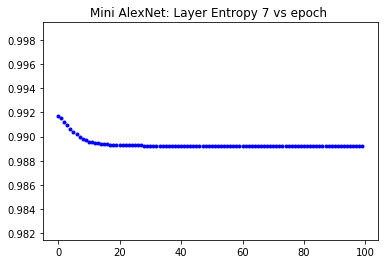

In [49]:
plt.scatter(range(0,len(w7_entropies)), w7_entropies, marker='.', color='blue')
#plt.scatter(range(0,len(w8_entropies)), w8_entropies, marker='.', color='green')
#lt.ylim([0.905,0.920])
plt.title('Mini AlexNet: Layer Entropy 7 vs epoch ')

Text(0.5,1,'Mini AlexNet: Layer Entropy 8 vs epoch ')

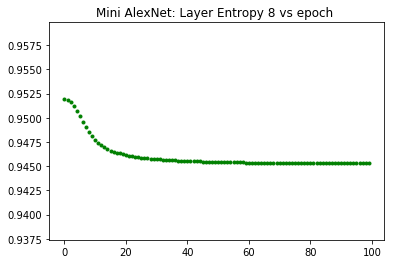

In [50]:
#plt.scatter(range(0,len(w7_entropies)), w7_entropies, marker='.', color='blue')
plt.scatter(range(0,len(w8_entropies)), w8_entropies, marker='.', color='green')
#lt.ylim([0.905,0.920])
plt.title('Mini AlexNet: Layer Entropy 8 vs epoch ')

#### Read Baseline Training accuracies from output file

Notice: there is no epoch=0 training accuracy

In [58]:
bsln_train_accs = read_training_accuracies(BASELINE_outfile)
assert(len(bsln_train_accs)==NUM_BASELINE_EPOCHS)

#### Recompute Baseline Test accuracies 

In [59]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [63]:
bsln_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(cifar10_test_images),np.array(cifar10_test_labels), batch_size=256)
    bsln_test_accs.append(acc[1])

10000/10000 [==============================] - 22s 2ms/step



Text(0.5,1,'Alexnet: Layer 7 & 8 Entropies vs epoch ')

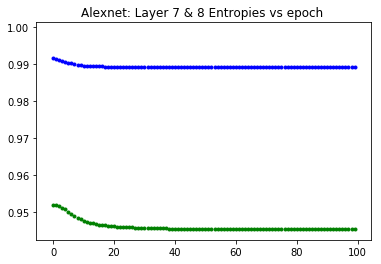

In [65]:
plt.scatter(range(0,len(w7_entropies)), w7_entropies, marker='.', color='blue')
plt.scatter(range(0,len(w8_entropies)), w8_entropies, marker='.', color='green')

plt.title('Alexnet: Layer 7 & 8 Entropies vs epoch ')

### Training and test Accuracies vs Epoch

In [69]:
len(bsln_train_accs), len(bsln_test_accs)

(100, 100)

Text(0.5,1,'AlexNet: Layer Entropies epoch vs generalized entropy')

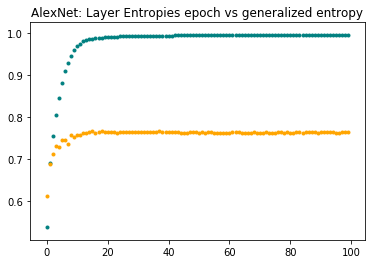

In [73]:
x = range(NUM_BASELINE_EPOCHS)

plt.scatter(x, bsln_train_accs,  marker='.',color='teal')
plt.scatter(x, bsln_test_accs,  marker='.',color='orange')

plt.title('AlexNet: Layer Entropies epoch vs generalized entropy')

## Marchenko Pastur FIts and Plots

$$\rho(\lambda)=\dfrac{Q}{2\pi\sigma_{mp}^{2}}\dfrac{(\lambda^{+}-\lambda)(\lambda^{-}-\lambda)}{\lambda}$$


$$\lambda^{\pm}=\sigma_{mp}^{2}\left(1\pm\dfrac{1}{\sqrt Q}\right)^{2}$$


In [74]:
def marchenko_pastur_pdf(x_min, x_max, Q, sigma=1):
    y=1/Q
    x=np.arange(x_min,x_max,0.001)

    b=np.power(sigma*(1 + np.sqrt(1/Q)),2) # Largest eigenvalue
    a=np.power(sigma*(1 - np.sqrt(1/Q)),2) # Smallest eigenvalue
    return x, (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))

#### Get sigma from $\lambda_{max}$

$$Q7=\dfrac{4096}{384}=10\frac{2}{3}$$

$$Q8=\dfrac{384}{192}=2$$


$$\sigma^{2}=\lambda_{max}\left(1+\dfrac{1}{\sqrt{Q}}\right)^{-2}$$

In [90]:
def calc_sigma(Q, evs):
    lmax = np.max(evs)
    inv_sqQ = 1.0/np.sqrt(Q)
    sigma_2 = lmax/np.square(1+inv_sqQ)
    sigma = np.sqrt(sigma_2)
    return sigma


In [76]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [77]:
def get_eigenvalues(modelfile, layer=7):
    model.load_weights(modelfile)
    W = model.layers[layer].get_weights()[0]
    N, M = W.shape[0], W.shape[1]

    X = np.dot(W.transpose(),W)/float(N)
    svd = TruncatedSVD(n_components=M-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    
    eigenvalues = sv*sv
    return eigenvalues

## Create 25 ESD plots, 5x5 grid

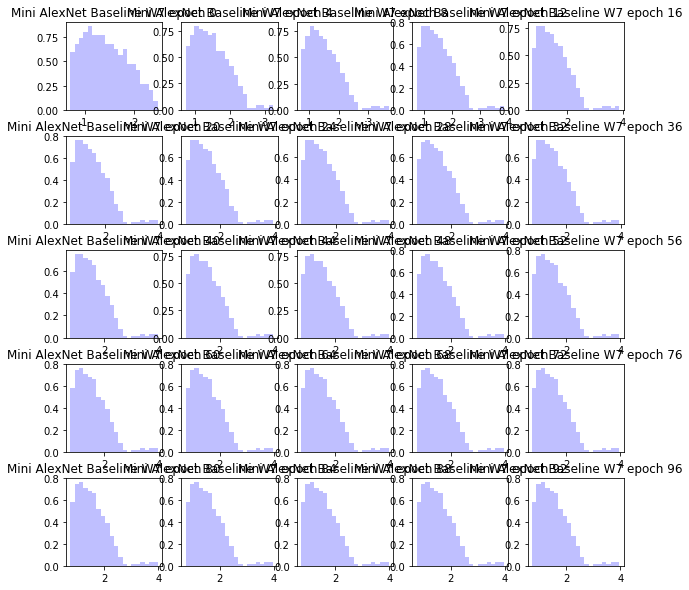

In [80]:
LAYER = 7
f, axes = plt.subplots(5,5)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = get_eigenvalues(modelfile, layer=LAYER)

    iay = idx % 5
    iax = int(idx / 5)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Mini AlexNet Baseline W{} epoch {}".format(LAYER,epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#fig = plt.figure()
#fig.savefig('MLP_W2_ESDs.png')

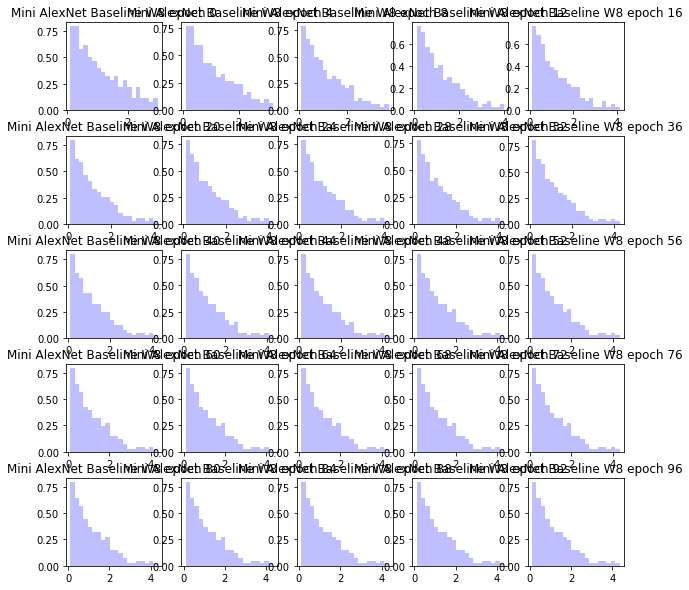

In [82]:
LAYER = 8
f, axes = plt.subplots(5,5)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = get_eigenvalues(modelfile, layer=LAYER)

    iay = idx % 5
    iax = int(idx / 5)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Mini AlexNet Baseline W{} epoch {}".format(LAYER,epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

#fig = plt.figure()
#fig.savefig('MLP_W2_ESDs.png')

### Fit Marchenko Pastur to ESD

#### Not so easy

0 2.4714327


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


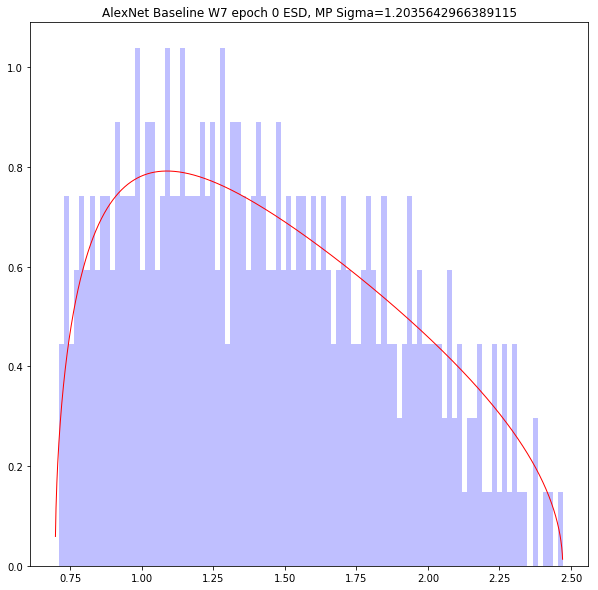

In [92]:
LAYER=7
EPOCH=0
Q = Q7

eigenvalues = get_eigenvalues(BASELINE_per_epoch_weightfile.format(EPOCH), LAYER)
plt.hist(eigenvalues, bins=100, alpha=0.25, color='blue', density=True);

SIGMA=calc_sigma(Q,eigenvalues)

ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)
print(x_min, x_max)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("AlexNet Baseline W{} epoch {} ESD, MP Sigma={}".format(LAYER,EPOCH,SIGMA));


0 3.8862996


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


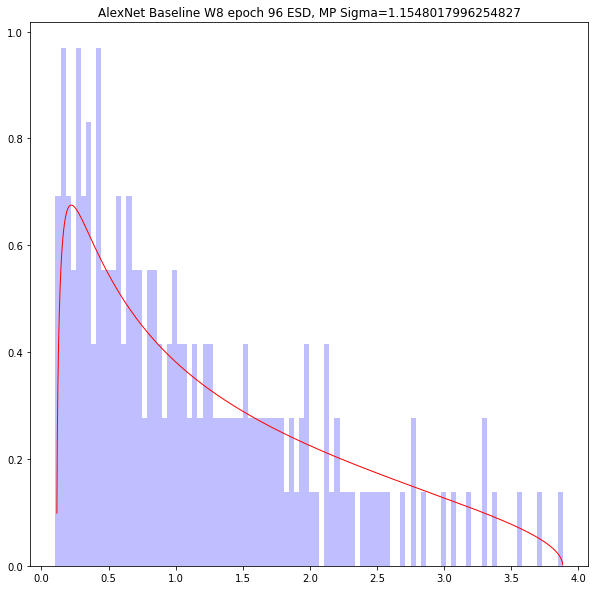

In [94]:
LAYER=8
EPOCH=0
Q = Q8

eigenvalues = get_eigenvalues(BASELINE_per_epoch_weightfile.format(10), layer=LAYER)
plt.hist(eigenvalues, bins=100, alpha=0.25, color='blue', density=True);

SIGMA=calc_sigma(Q, eigenvalues)

ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)
print(x_min, x_max)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("AlexNet Baseline W{} epoch {} ESD, MP Sigma={}".format(LAYER,epoch,SIGMA));


/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


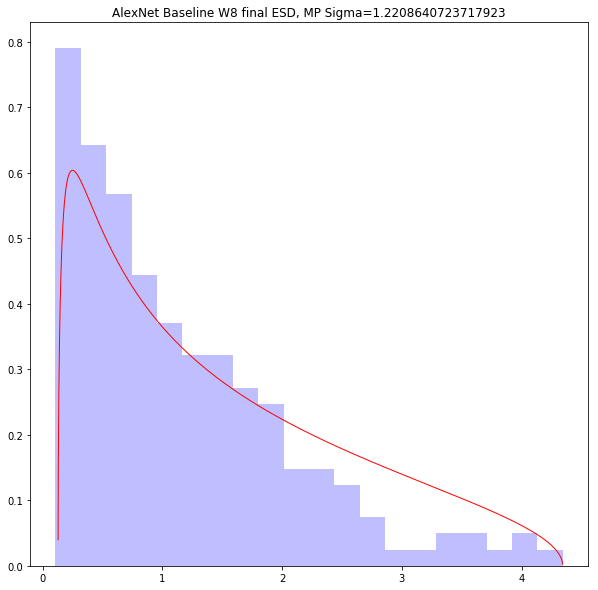

In [104]:
LAYER=8
EPOCH=0
Q = Q8

eigenvalues = get_eigenvalues(BASELINE_final_weightfile, LAYER)
plt.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);

SIGMA=calc_sigma(Q, eigenvalues)

ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("AlexNet Baseline W{} final ESD, MP Sigma={}".format(LAYER,SIGMA));

### SPIKES SEEM TO APPEAR..BUT THEY ARE HARD TO FIND

/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/charlesmartin14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


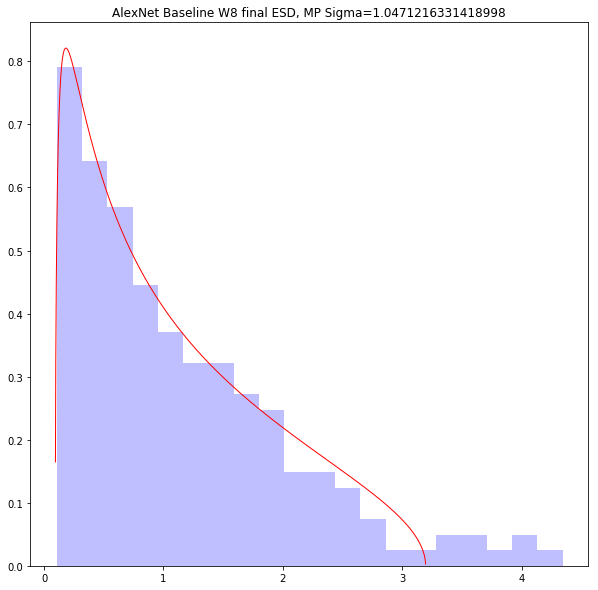

In [111]:
LAYER=8
EPOCH=0
Q = Q8

eigenvalues = get_eigenvalues(BASELINE_final_weightfile, LAYER)
plt.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);

SIGMA=calc_sigma(Q, eigenvalues[8:])


ev = np.array(eigenvalues)
x_min, x_max =  0, np.max(eigenvalues)

x, mp = marchenko_pastur_pdf(x_min, x_max, Q, sigma=SIGMA)
plt.plot(x,mp, linewidth=1, color = 'r')
plt.title("AlexNet Baseline W{} final ESD, MP Sigma={}".format(LAYER,SIGMA));

## Scree Plots:  

In [149]:
# Eigenvalues for correlation weight matrices, layers 7 and 8 
# for Scree plots
def matrix_eigenvalues():
    W = model.layers[7].get_weights()[0]
    W = W / np.linalg.norm(W)
    WW = np.dot(W.transpose(),W)#/float(N7)
    ev7s, _ = np.linalg.eig(WW)    
    
    W = model.layers[8].get_weights()[0]
    W = W / np.linalg.norm(W)
    WW = np.dot(W.transpose(),W)#/float(N8)
    ev8s, _ = np.linalg.eig(WW)  
    
    return ev7s, ev8s

In [169]:
def scree_plot(filename, colors=['blue', 'green']):
    
    model.load_weights(filename)
    ev7s, ev8s = matrix_eigenvalues()
    eigvals = np.flip(np.sort(ev7s), axis=0)
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals, colors[0], linewidth=1)

    eigvals = np.flip(np.sort(ev8s), axis=0)
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals,  colors[1], linewidth=1)


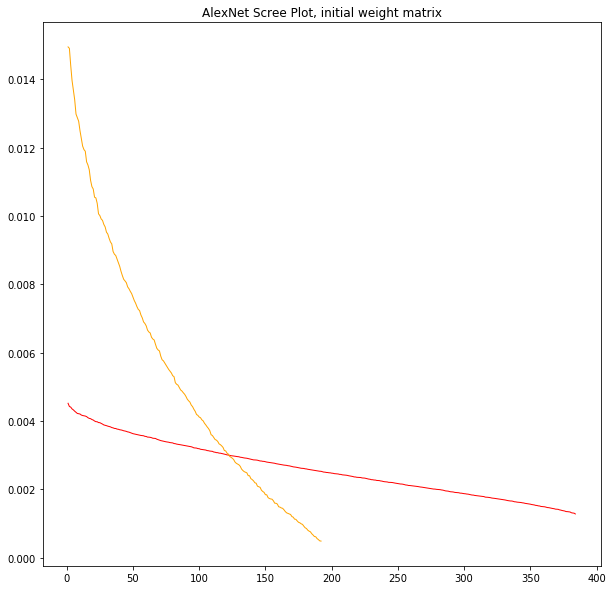

In [170]:
scree_plot(BASELINE_init_weighfile, colors=['red', 'orange'])
plt.title("AlexNet Scree Plot, initial weight matrix")
plt.show()


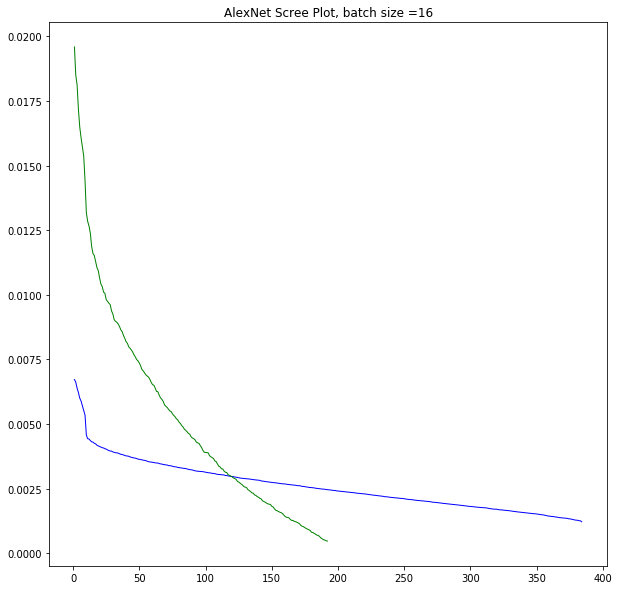

In [171]:
scree_plot(BASELINE_final_weightfile)
plt.title("AlexNet Scree Plot, batch size =16")
plt.show()

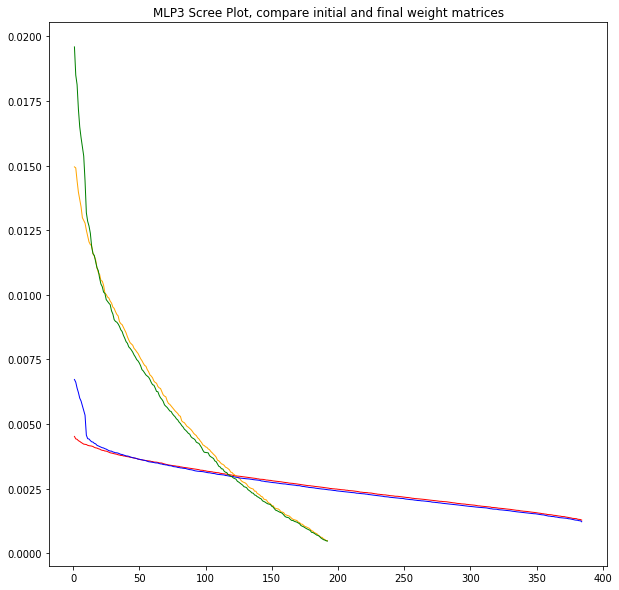

In [172]:
scree_plot(BASELINE_init_weighfile, colors=['red', 'orange'])
scree_plot(BASELINE_final_weightfile)
plt.title("MLP3 Scree Plot, compare initial and final weight matrices")
plt.show()